In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
df = pd.read_csv('../Data/tsla.csv')
df.head()

,Date,Close,High,Low,Open,Volume
0,2015-07-01,17.943333,18.174667,17.856667,18.073999,31518000
1,2015-07-02,18.667999,18.830000,18.220667,18.680000,107458500
2,2015-07-06,18.648001,18.779333,18.420000,18.591999,61828500
3,2015-07-07,17.858667,18.346666,17.384666,18.333332,91576500
4,2015-07-08,16.997334,17.386667,16.954000,17.288000,93316500


In [3]:
df.set_index('Date', inplace=True)
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-07-01,17.943333,18.174667,17.856667,18.073999,31518000
2015-07-02,18.667999,18.830000,18.220667,18.680000,107458500
2015-07-06,18.648001,18.779333,18.420000,18.591999,61828500
2015-07-07,17.858667,18.346666,17.384666,18.333332,91576500
2015-07-08,16.997334,17.386667,16.954000,17.288000,93316500


In [4]:
feature_col = 'Close'
n_steps = 10

In [6]:
values = df[[feature_col]].values

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

In [10]:
# 4. Create sequences
def create_sequences(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [12]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [14]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# 7. Train
model.fit(X_train, y_train, epochs=200, verbose=0)

In [16]:
# 8. Predict
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [18]:
# 9. Inverse transform
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

In [ ]:
# 10. Display results
for actual, pred in zip(y_test_inv.flatten(), y_pred_inv.flatten()):
    print(f"Actual: {actual:.4f}, Predicted: {pred:.4f}")

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate on inverse-scaled values
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print("\nModel Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error):     {mae:.4f}")
print(f"MSE  (Mean Squared Error):      {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R²   (R-squared):               {r2:.4f}")



Model Evaluation Metrics:
MAE  (Mean Absolute Error):     7.5073
MSE  (Mean Squared Error):      117.2362
RMSE (Root Mean Squared Error): 10.8276
R²   (R-squared):               0.9753


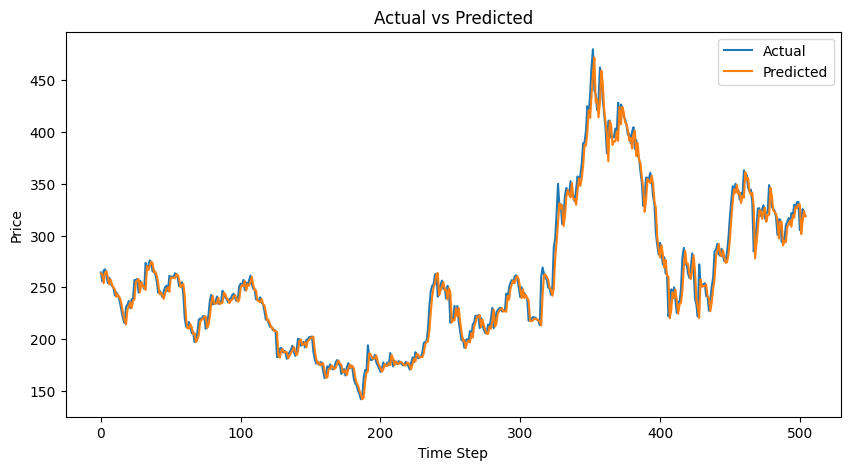

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()


Check for overfitting

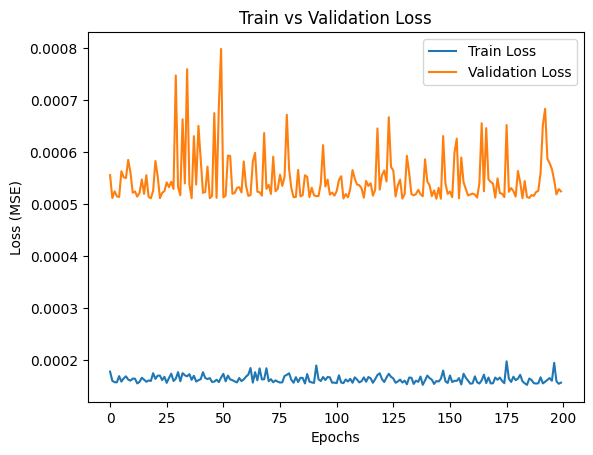

In [22]:
import matplotlib.pyplot as plt

# Train model and save history
history = model.fit(X_train, y_train, epochs=200, verbose=0, validation_data=(X_test, y_test))

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [23]:
# Predict on training data
y_train_pred = model.predict(X_train)
y_train_inv = scaler.inverse_transform(y_train)
y_train_pred_inv = scaler.inverse_transform(y_train_pred)

# Metrics on train
from sklearn.metrics import mean_squared_error, r2_score
train_mse = mean_squared_error(y_train_inv, y_train_pred_inv)
train_r2 = r2_score(y_train_inv, y_train_pred_inv)
print(f"Train RMSE: {np.sqrt(train_mse):.4f}")
print(f"Train R²:   {train_r2:.4f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Train RMSE: 5.7695
Train R²:   0.9973


Adding Dropout

In [34]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

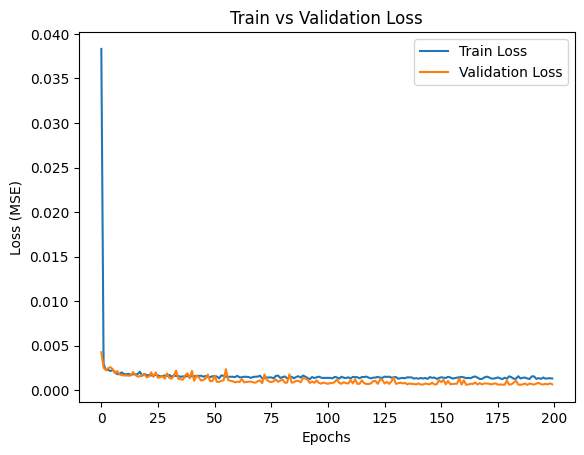

In [35]:
history = model.fit(X_train, y_train, epochs=200, verbose=0, validation_data=(X_test, y_test))

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

Save scaler

In [42]:
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Save the model

In [36]:
model.save('lstm_stock_model.h5')


In [38]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/lstm_stock_model.h5', compile=False)


In [39]:
# 8. Predict
y_pred = model.predict(X_test)
# 9. Inverse transform
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate on inverse-scaled values
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print("\nModel Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error):     {mae:.4f}")
print(f"MSE  (Mean Squared Error):      {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R²   (R-squared):               {r2:.4f}")



Model Evaluation Metrics:
MAE  (Mean Absolute Error):     8.3526
MSE  (Mean Squared Error):      147.0694
RMSE (Root Mean Squared Error): 12.1272
R²   (R-squared):               0.9690


Done...


In [41]:
last_sequence = X[-1]
last_sequence

array([[0.6636274 ],
       [0.65882176],
       [0.68059591],
       [0.67812929],
       [0.68582679],
       [0.68678369],
       [0.62881845],
       [0.65169836],
       [0.67196279],
       [0.662628  ]])

In [26]:
# 8. Predict
y_pred = model.predict(X_test)
# 9. Inverse transform
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate on inverse-scaled values
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print("\nModel Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error):     {mae:.4f}")
print(f"MSE  (Mean Squared Error):      {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R²   (R-squared):               {r2:.4f}")



Model Evaluation Metrics:
MAE  (Mean Absolute Error):     8.6353
MSE  (Mean Squared Error):      151.0963
RMSE (Root Mean Squared Error): 12.2921
R²   (R-squared):               0.9681


More Layers

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps, 1)),
    Dropout(0.2),  # Optional: reduce overfitting
    LSTM(32),  # Second LSTM layer
    #Dropout(0.2),
    Dense(1)  # Final output layer
])

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


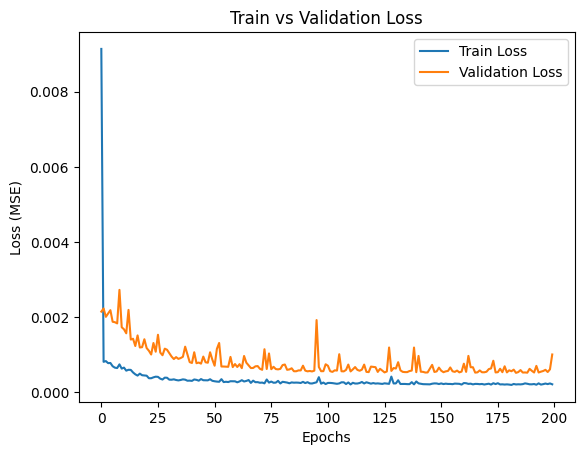

In [33]:
history = model.fit(X_train, y_train, epochs=200, verbose=0, validation_data=(X_test, y_test))

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [30]:
# 8. Predict
y_pred = model.predict(X_test)
# 9. Inverse transform
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate on inverse-scaled values
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print("\nModel Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error):     {mae:.4f}")
print(f"MSE  (Mean Squared Error):      {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R²   (R-squared):               {r2:.4f}")



Model Evaluation Metrics:
MAE  (Mean Absolute Error):     9.0688
MSE  (Mean Squared Error):      164.5684
RMSE (Root Mean Squared Error): 12.8284
R²   (R-squared):               0.9653
